In [1]:
# # Feedforward / CNN Image Classification on CIFAR-10
# - Stages:
#   1. Loading & preprocessing data
#   2. Defining model architecture
#   3. Training (SGD)
#   4. Estimating performance (evaluation, plots, confusion matrix)
# - Framework: TensorFlow / Keras


In [2]:
# Cell 1 — Imports, reproducibility, and small utilities
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

# Reproducibility (best-effort)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.18.0


x_train: (50000, 32, 32, 3) y_train: (50000, 1)
x_test : (10000, 32, 32, 3) y_test : (10000, 1)


C:\Users\SAHIL KULKARNI\AppData\Local\Temp\ipykernel_9140\2490530462.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Label (raw): {int(y_train[25])}")


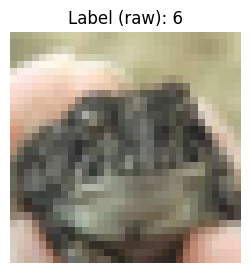

In [3]:
# Cell 2 — Stage (a): Load CIFAR-10 data and quick inspection
# CIFAR-10: 50k train, 10k test, images 32x32x3

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test :", x_test.shape, "y_test :", y_test.shape)

# Show one example (raw)
plt.figure(figsize=(3,3))
plt.imshow(x_train[25])
plt.title(f"Label (raw): {int(y_train[25])}")
plt.axis("off")
plt.show()


In [4]:
# ------------------ Cell 4 ------------------
# Data augmentation pipeline (must be executed BEFORE model definition)
from tensorflow import keras

# Ensure num_classes exists (if not, set default)
try:
    num_classes
except NameError:
    num_classes = 10

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),       # random left-right flip
    keras.layers.RandomRotation(0.08),          # small random rotations
    keras.layers.RandomZoom(0.05),              # small random zooms
], name="data_augmentation")

# quick sanity check (optional)
print("Data augmentation pipeline created:", data_augmentation)

Data augmentation pipeline created: <Sequential name=data_augmentation, built=False>


In [5]:
# ------------------ Cell 5 ------------------
# Define model architecture (uses data_augmentation defined above)

from tensorflow import keras
from tensorflow.keras import layers, models

def build_cifar_cnn(data_aug_layer=None):
    """
    Builds a small CNN for CIFAR-10.
    If data_aug_layer is provided, it will be applied to the input.
    """
    inputs = keras.Input(shape=(32,32,3))
    x = data_aug_layer(inputs) if data_aug_layer is not None else inputs

    # Block 1
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv1')(x)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)

    # Block 2
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same', name='conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)

    # Block 3
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same', name='conv3')(x)

    # Classifier head
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(64, activation='relu', name='fc1')(x)
    x = layers.Dropout(0.5, name='dropout')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="cifar_cnn")
    return model

# Build model using the augmentation layer created in Cell 4
model = build_cifar_cnn(data_augmentation)
model.summary()


Model: "cifar_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 64)                  │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 319,178 (1.22 MB)

 Trainable params: 319,178 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Cell 6 — Stage (c): Compile model using SGD (as required)
# You can switch to Adam by changing optimizer below if you wish.

learning_rate = 0.01
momentum = 0.9

optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=False)
# Alternatively: optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",   # labels are one-hot encoded
    metrics=["accuracy"]
)


In [7]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

batch_size = 64
epochs = 12

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_cifar_model.keras", save_best_only=True, monitor="val_loss"
)
earlystop_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

history = model.fit(
    x_train, y_train_cat,
    validation_split=0.1,   # keep 10% of train as validation
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb],
    verbose=2
)


Epoch 1/12
704/704 - 106s - 150ms/step - accuracy: 0.0997 - loss: 14930433689750377332736.0000 - val_accuracy: 0.1064 - val_loss: 2.3025 - learning_rate: 0.0100
Epoch 2/12
704/704 - 85s - 121ms/step - accuracy: 0.0992 - loss: 2.3031 - val_accuracy: 0.1064 - val_loss: 2.3025 - learning_rate: 0.0100
Epoch 3/12
704/704 - 83s - 119ms/step - accuracy: 0.0992 - loss: 2.3031 - val_accuracy: 0.1064 - val_loss: 2.3025 - learning_rate: 0.0100
Epoch 4/12
704/704 - 84s - 120ms/step - accuracy: 0.0992 - loss: 2.3031 - val_accuracy: 0.1064 - val_loss: 2.3025 - learning_rate: 0.0100
Epoch 5/12
704/704 - 84s - 119ms/step - accuracy: 0.0973 - loss: 2.3029 - val_accuracy: 0.1064 - val_loss: 2.3024 - learning_rate: 0.0050
Epoch 6/12
704/704 - 73s - 104ms/step - accuracy: 0.0978 - loss: 2.3029 - val_accuracy: 0.1064 - val_loss: 2.3024 - learning_rate: 0.0050
Epoch 7/12
704/704 - 82s - 116ms/step - accuracy: 0.0980 - loss: 2.3029 - val_accuracy: 0.1064 - val_loss: 2.3024 - learning_rate: 0.0050
Epoch 8/12


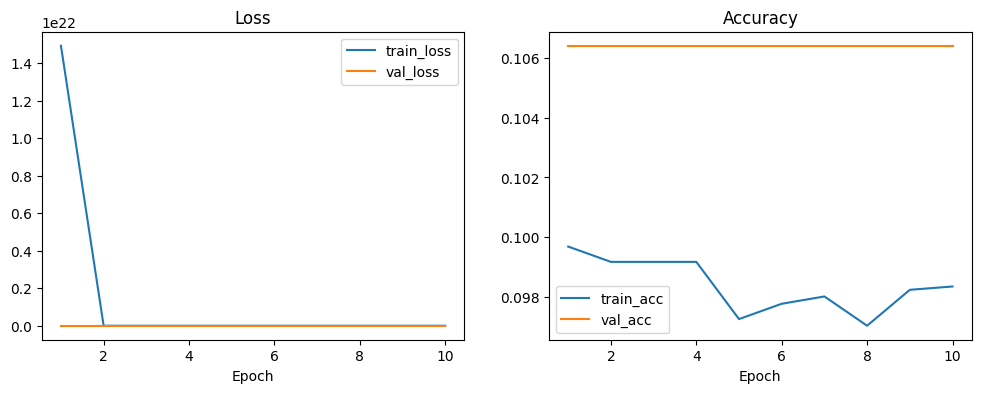

In [8]:
# Cell 8 — Stage (d): Plot training / validation loss and accuracy
hist = history.history
epochs_range = range(1, len(hist['loss'])+1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, hist['loss'], label='train_loss')
plt.plot(epochs_range, hist['val_loss'], label='val_loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, hist['accuracy'], label='train_acc')
plt.plot(epochs_range, hist['val_accuracy'], label='val_acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()


In [9]:
# Cell 9 — Stage (d) continued: Evaluate on test set (numbers)
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test Loss: {test_loss:.4f}   Test Accuracy: {test_acc:.4f}")


Test Loss: 2.3026   Test Accuracy: 0.1000


C:\Users\SAHIL KULKARNI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
704/704 - 43s - 61ms/step - accuracy: 0.4390 - loss: 1.5390 - val_accuracy: 0.5186 - val_loss: 1.3260 - learning_rate: 0.0010
Epoch 2/10
704/704 - 41s - 59ms/step - accuracy: 0.5915 - loss: 1.1579 - val_accuracy: 0.6200 - val_loss: 1.0925 - learning_rate: 0.0010
Epoch 3/10
704/704 - 41s - 58ms/step - accuracy: 0.6571 - loss: 0.9811 - val_accuracy: 0.6704 - val_loss: 0.9568 - learning_rate: 0.0010
Epoch 4/10
704/704 - 44s - 63ms/step - accuracy: 0.6991 - loss: 0.8635 - val_accuracy: 0.6986 - val_loss: 0.8761 - learning_rate: 0.0010
Epoch 5/10
704/704 - 34s - 49ms/step - accuracy: 0.7290 - loss: 0.7768 - val_accuracy: 0.6986 - val_loss: 0.8679 - learning_rate: 0.0010
Epoch 6/10
704/704 - 37s - 52ms/step - accuracy: 0.7572 - loss: 0.7036 - val_accuracy: 0.7074 - val_loss: 0.8556 - learning_rate: 0.0010
Epoch 7/10
704/704 - 61s - 86ms/step - accuracy: 0.7763 - loss: 0.6431 - val_accuracy: 0.7178 - val_loss: 0.8355 - learning_rate: 0.0010
Epoch 8/10
704/704 - 59s - 84ms/step - ac

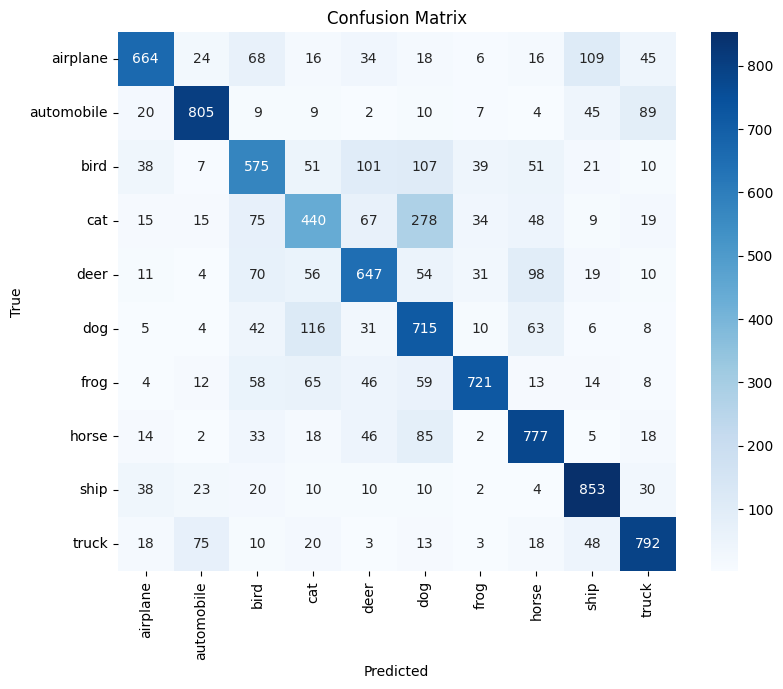


Classification Report:

              precision    recall  f1-score   support

    airplane      0.803     0.664     0.727      1000
  automobile      0.829     0.805     0.817      1000
        bird      0.599     0.575     0.587      1000
         cat      0.549     0.440     0.489      1000
        deer      0.656     0.647     0.651      1000
         dog      0.530     0.715     0.609      1000
        frog      0.843     0.721     0.777      1000
       horse      0.712     0.777     0.743      1000
        ship      0.756     0.853     0.801      1000
       truck      0.770     0.792     0.781      1000

    accuracy                          0.699     10000
   macro avg      0.705     0.699     0.698     10000
weighted avg      0.705     0.699     0.698     10000



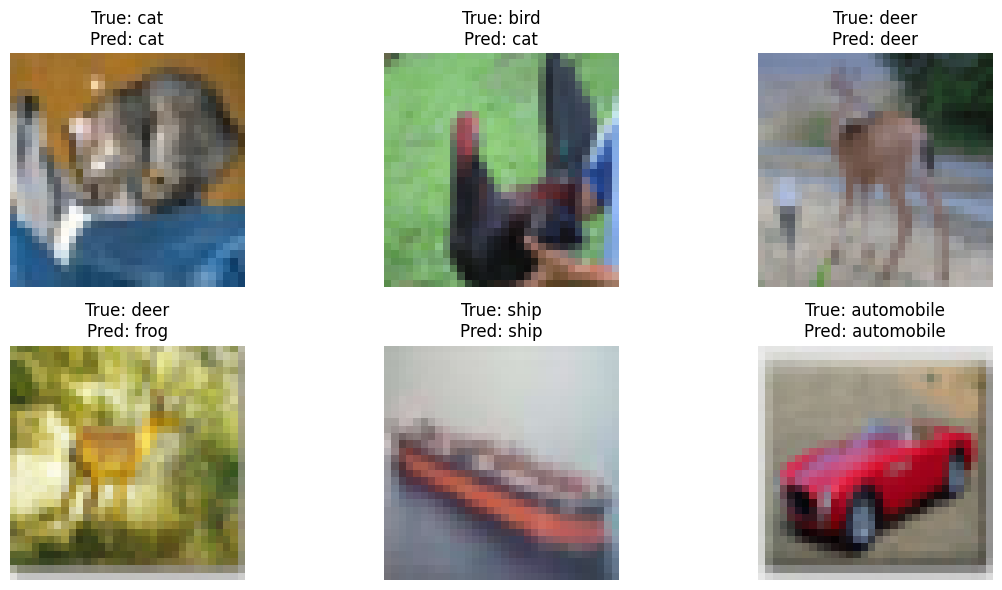

In [10]:
# ------------------ IMPORTS ------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------ LOAD + PREPROCESS DATA ------------------
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

# Normalize images to 0–1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

# Class names
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# ------------------ BUILD MODEL ------------------
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # CIFAR-10 = 10 classes
])

# Compile with correct loss for one-hot labels
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ------------------ TRAIN ------------------
batch_size = 64
epochs = 10

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_cifar_model.keras", save_best_only=True, monitor="val_loss"
)
earlystop_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2
)

history = model.fit(
    x_train, y_train_cat,
    validation_split=0.1,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb],
    verbose=2
)

# ------------------ EVALUATE ------------------
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"\n✅ Test accuracy: {test_acc*100:.2f}%")

# ------------------ CONFUSION MATRIX + REPORT ------------------
y_pred_probs = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))




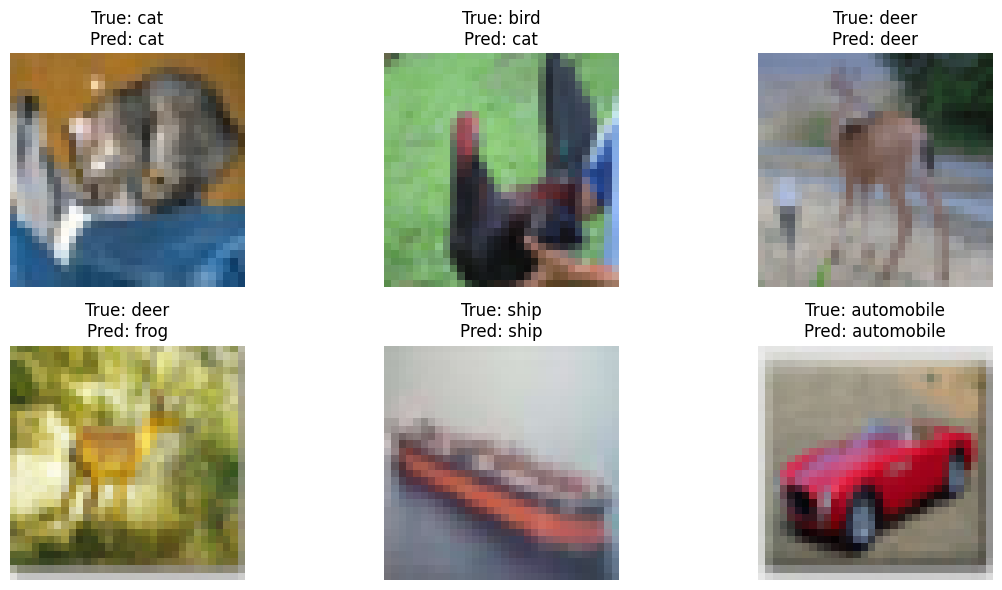

In [11]:
# Cell 11 — Visualize some sample predictions (qualitative check)
def show_preds(indices):
    plt.figure(figsize=(12,6))
    for i, idx in enumerate(indices):
        plt.subplot(2, len(indices)//2, i+1)
        plt.imshow(x_test[idx])
        pred = class_names[y_pred[idx]]
        true = class_names[y_true[idx]]
        plt.title(f"True: {true}\nPred: {pred}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_preds([0, 25, 100, 500, 999, 1234])


In [12]:
# Cell 12 — Save final model (best weights already restored by EarlyStopping if used)
model.save("final_cifar_cnn.keras")
print("Saved model to final_cifar_cnn.keras")


Saved model to final_cifar_cnn.keras


In [ ]:
# 🧠 PART 1: What this experiment is about (in simple words)
# This practical is about building an Image Classification Model using Keras and TensorFlow, step by step.
# We train a computer to recognize images from the CIFAR-10 dataset — a popular dataset with:
# •	50,000 training images and 10,000 testing images
# •	Each image is 32×32 pixels, color (RGB)
# •	There are 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
# The model is built in 4 stages:
# 1.	Loading and Preprocessing the image data
# 2.	Defining the Model’s Architecture
# 3.	Training the Model
# 4.	Estimating Model Performance (evaluation, graphs, confusion matrix)
# ________________________________________
# 📘 PART 2: Exam-ready notes (for your journal)
# 🧩 Title
# Build the Image Classification Model by dividing it into 4 stages:
# a. Loading and preprocessing the image data
# b. Defining the model’s architecture
# c. Training the model
# d. Estimating the model’s performance
# ________________________________________
# 🎯 Aim
# To develop and train an image classification model using Keras and TensorFlow on the CIFAR-10 dataset, and evaluate its performance.
# ________________________________________
# 🧠 Theory (in simple words)
# •	Image Classification means automatically predicting which class an image belongs to (for example, “dog” or “car”).
# •	A Convolutional Neural Network (CNN) or Feedforward Neural Network (FFN) can be used for this purpose.
# •	CNNs are better because they detect spatial features (edges, colors, shapes).
# •	The process includes:
# 1.	Loading the dataset
# 2.	Normalizing image pixel values (0–1 range)
# 3.	Building a neural network (layers)
# 4.	Training it to minimize loss
# 5.	Checking accuracy and visualizing results

# ✅ Conclusion
# •	The experiment demonstrates the full workflow of building an image classifier using deep learning.
# •	Dividing the process into stages (load, define, train, evaluate) helps understand each step clearly.
# •	CNNs work efficiently for image classification tasks.
# ________________________________________
# 💬 Viva Questions and Simple Answers
# Question	Simple Answer
# What dataset is used?	CIFAR-10, with 10 classes of colored images.
# Why normalize the image data?	To keep pixel values small and make training stable.
# What optimizer was used?	Stochastic Gradient Descent (SGD).
# What is the activation function used?	ReLU for hidden layers, Softmax for output.
# What is the purpose of the Flatten layer?	Converts 2D image data into a 1D vector before Dense layers.
# What does a convolution layer do?	It extracts local features like edges or colors from the image.
# What does pooling do?	Reduces the image size and helps the model focus on important features.
# Why use softmax in output?	It converts model output into class probabilities.
